In [9]:
# 🔧 DISTANCE VALIDATION CONFIGURATION
# ===================================
# Configure the new distance validation filter

from utils.sonar_config import IMAGE_PROCESSING_CONFIG

print(f"🎛️  Current distance validation setting: {IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True)}")

# Option 1: Keep distance validation ON (default - filters invalid measurements)
# IMAGE_PROCESSING_CONFIG['use_distance_validation'] = True

# Option 2: Turn distance validation OFF (raw distances, may have jumps/errors)  
# IMAGE_PROCESSING_CONFIG['use_distance_validation'] = False

print("\n📋 Distance Validation Options:")
print("   ✅ use_distance_validation = True  → Filters negative/out-of-bounds distances")
print("   ⚠️  use_distance_validation = False → Raw distances (may have jumps/errors)")
print(f"\n🎯 Filter Description:")
print("   • Ensures distance is never negative")
print("   • Ensures distance is within image bounds (0 to image height)")
print("   • Uses last valid distance when current measurement is invalid")
print(f"   • Current setting: {'ENABLED' if IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True) else 'DISABLED'}")

🎛️  Current distance validation setting: True

📋 Distance Validation Options:
   ✅ use_distance_validation = True  → Filters negative/out-of-bounds distances
   ⚠️  use_distance_validation = False → Raw distances (may have jumps/errors)

🎯 Filter Description:
   • Ensures distance is never negative
   • Ensures distance is within image bounds (0 to image height)
   • Uses last valid distance when current measurement is invalid
   • Current setting: ENABLED


# 🔍 Net Detection Pipeline Visualization

This section creates individual figures to visualize each step in the net detection pipeline. Each step shows the transformation of the sonar image as it progresses through the processing stages.

## Pipeline Overview:
1. **Original Frame** - Raw sonar data (uint8 grayscale)
2. **Momentum Enhancement** - Directional momentum merge for sharper objects  
3. **Edge Detection** - Canny edge detection on enhanced image
4. **Edge Processing** - Morphological operations (close + dilate)
5. **Contour Detection** - Find contours from processed edges
6. **Contour Selection** - Select best contour based on area, elongation, and tracking
7. **Final Result** - Distance measurement and AOI tracking

In [11]:
# Import required libraries for pipeline visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.sonar_image_analysis import (
    prepare_input_gray, preprocess_edges, 
    select_best_contour_core, compute_contour_features,
    SonarDataProcessor, FrameAnalysisResult,
    to_uint8_gray, get_available_npz_files, load_cone_run_npz,
    _distance_angle_from_contour
)
import utils.sonar_image_analysis as iau
from utils.sonar_config import IMAGE_PROCESSING_CONFIG, TRACKING_CONFIG

# Set the frame to analyze (you can change this)
DEMO_FRAME_INDEX = 50

print("📚 Libraries imported for pipeline visualization")
print(f"🎯 Demo frame index: {DEMO_FRAME_INDEX}")
print("✅ Ready to visualize the net detection pipeline!")

📚 Libraries imported for pipeline visualization
🎯 Demo frame index: 50
✅ Ready to visualize the net detection pipeline!


In [12]:
# Load the frame for pipeline demonstration
try:
    # Method 1: Try to use existing loaded NPZ data
    if 'cones' in locals() and len(cones) > DEMO_FRAME_INDEX:
        demo_frame = to_uint8_gray(cones[DEMO_FRAME_INDEX])
        print(f"✅ Loaded frame {DEMO_FRAME_INDEX} from existing NPZ data")
    else:
        # Method 2: Load from NPZ file using the utility functions
        print(f"🔄 Loading frame {DEMO_FRAME_INDEX} from NPZ file...")
        
        # Get available NPZ files
        npz_files = get_available_npz_files()
        if not npz_files:
            raise FileNotFoundError("No NPZ files found in the default directory")
        
        # Use the first NPZ file or the specified index
        npz_file_index = locals().get('NPZ_FILE_INDEX', 0)
        if npz_file_index >= len(npz_files):
            npz_file_index = 0
            print(f"⚠️ NPZ_FILE_INDEX out of range, using index 0")
        
        # Load the NPZ data
        cones, timestamps, extent, meta = load_cone_run_npz(npz_files[npz_file_index])
        
        # Check if frame index is valid
        if DEMO_FRAME_INDEX >= len(cones):
            DEMO_FRAME_INDEX = len(cones) // 2  # Use middle frame
            print(f"⚠️ Frame index out of range, using middle frame: {DEMO_FRAME_INDEX}")
        
        # Convert frame to uint8 grayscale
        demo_frame = to_uint8_gray(cones[DEMO_FRAME_INDEX])
        
        # Store variables for other cells to use
        globals()['cones'] = cones
        globals()['extent'] = extent
        globals()['DEMO_FRAME_INDEX'] = DEMO_FRAME_INDEX
        
        print(f"✅ Loaded frame {DEMO_FRAME_INDEX} from NPZ file: {npz_files[npz_file_index].name}")
    
    print(f"📐 Frame shape: {demo_frame.shape}")
    print(f"📊 Frame dtype: {demo_frame.dtype}")
    print(f"🎨 Pixel range: {demo_frame.min()} - {demo_frame.max()}")
    
    # Store the frame for other cells
    globals()['demo_frame'] = demo_frame
    
except Exception as e:
    print(f"❌ Error loading frame: {e}")
    print("💡 Troubleshooting suggestions:")
    print("   • Ensure NPZ files exist in the data directory")
    print("   • Check that the frame index is within range")
    print("   • Try running earlier cells to load data first")

✅ Loaded frame 50 from existing NPZ data
📐 Frame shape: (700, 900)
📊 Frame dtype: uint8
🎨 Pixel range: 0 - 255


## Step 1: Original Frame - Raw Sonar Data

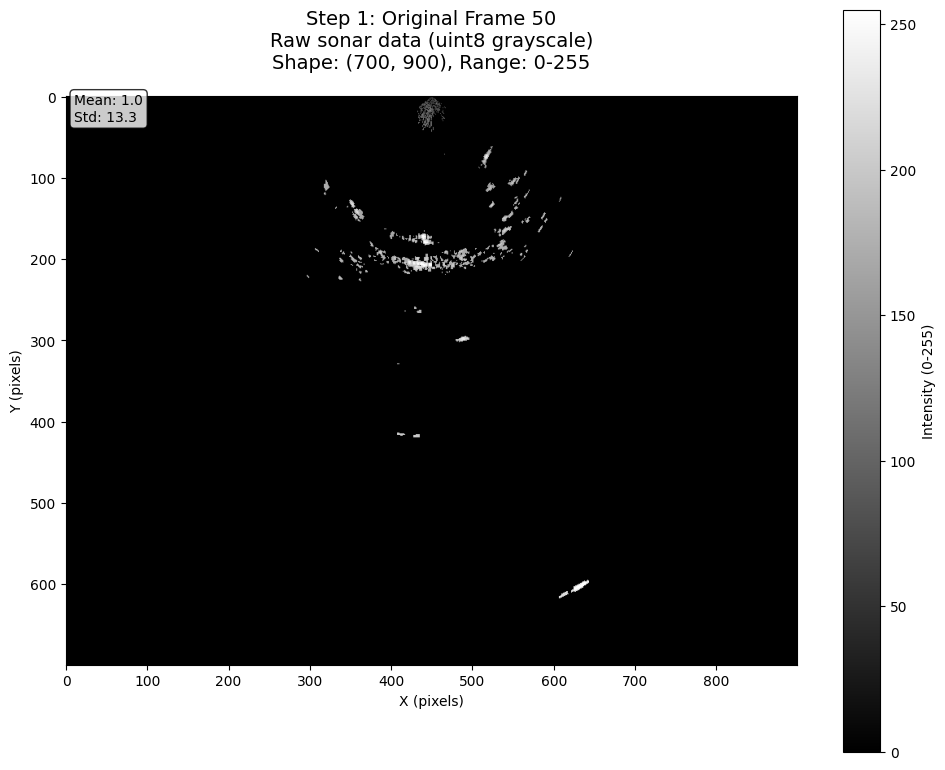

📊 Frame statistics:
   • Mean intensity: 0.98
   • Standard deviation: 13.28
   • Non-zero pixels: 3614/630000 (0.6%)


In [13]:
# STEP 1: Original Frame Visualization
if 'demo_frame' in locals():
    plt.figure(figsize=(10, 8))
    plt.imshow(demo_frame, cmap='gray', aspect='equal')
    plt.title(f'Step 1: Original Frame {DEMO_FRAME_INDEX}\n'
              f'Raw sonar data (uint8 grayscale)\n'
              f'Shape: {demo_frame.shape}, Range: {demo_frame.min()}-{demo_frame.max()}', 
              fontsize=14, pad=20)
    plt.colorbar(label='Intensity (0-255)')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    
    # Add some statistics as text
    mean_intensity = np.mean(demo_frame)
    std_intensity = np.std(demo_frame)
    plt.text(10, 30, f'Mean: {mean_intensity:.1f}\nStd: {std_intensity:.1f}', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Frame statistics:")
    print(f"   • Mean intensity: {mean_intensity:.2f}")
    print(f"   • Standard deviation: {std_intensity:.2f}")
    print(f"   • Non-zero pixels: {np.count_nonzero(demo_frame)}/{demo_frame.size} ({100*np.count_nonzero(demo_frame)/demo_frame.size:.1f}%)")
else:
    print("❌ Demo frame not available. Please run the previous cell first.")

## Step 2: Momentum Enhancement - Sharper Object Boundaries

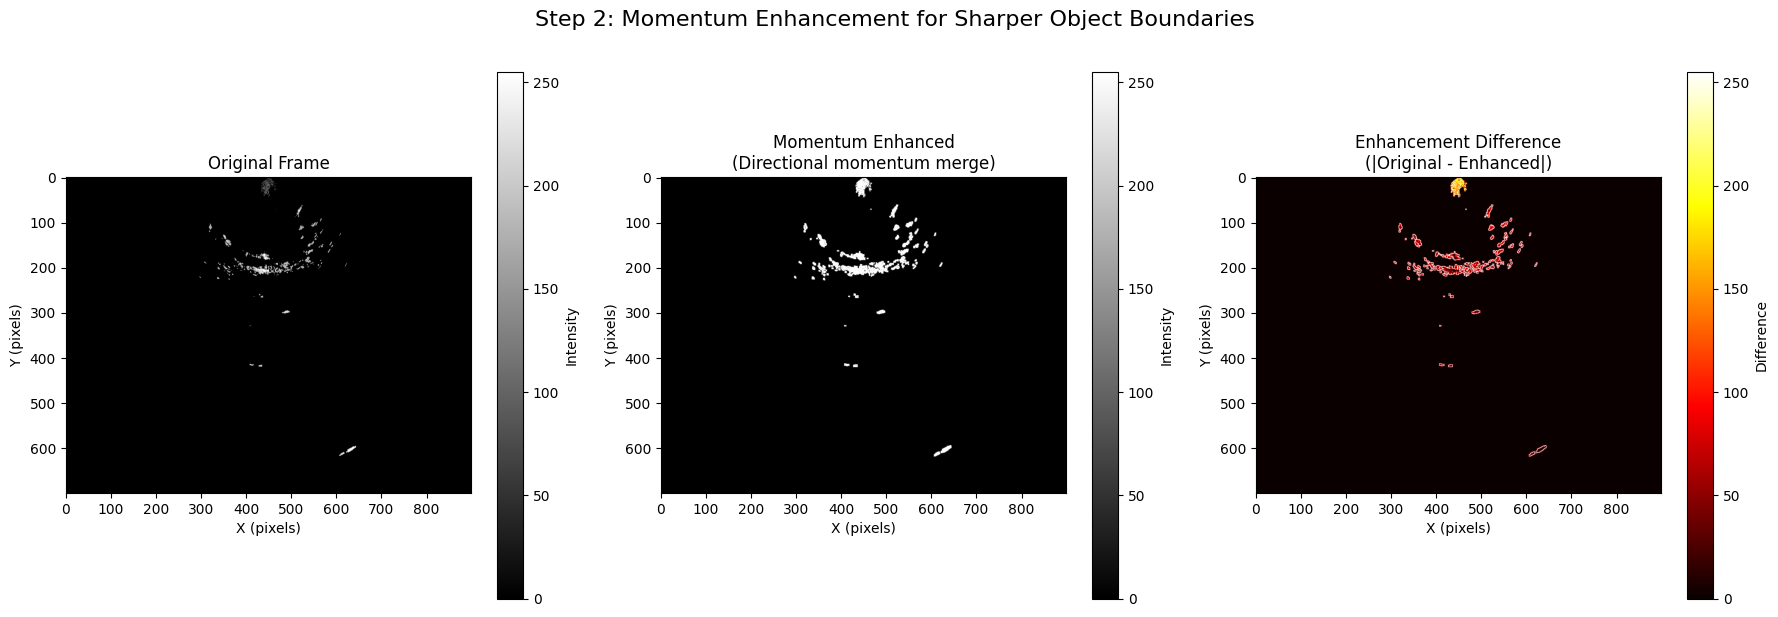

🔧 Momentum Enhancement Configuration:
   • Search radius: 10
   • Momentum threshold: 0.1
   • Momentum decay: 0.9
   • Momentum boost: 10.0

📊 Enhancement Statistics:
   • Mean enhancement: 2.15
   • Max enhancement: 255.00
   • Enhanced pixels: 10359/630000 (1.6%)


In [8]:
# STEP 2: Momentum Enhancement
if 'demo_frame' in locals():
    # Apply momentum enhancement (prepare_input_gray uses directional_momentum_merge)
    momentum_enhanced = prepare_input_gray(demo_frame, IMAGE_PROCESSING_CONFIG)
    
    # Create comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original
    im1 = axes[0].imshow(demo_frame, cmap='gray', aspect='equal')
    axes[0].set_title('Original Frame', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=axes[0], label='Intensity')
    
    # Enhanced
    im2 = axes[1].imshow(momentum_enhanced, cmap='gray', aspect='equal')
    axes[1].set_title('Momentum Enhanced\n(Directional momentum merge)', fontsize=12)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=axes[1], label='Intensity')
    
    # Difference
    diff = cv2.absdiff(demo_frame, momentum_enhanced)
    im3 = axes[2].imshow(diff, cmap='hot', aspect='equal')
    axes[2].set_title('Enhancement Difference\n(|Original - Enhanced|)', fontsize=12)
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    plt.colorbar(im3, ax=axes[2], label='Difference')
    
    plt.suptitle('Step 2: Momentum Enhancement for Sharper Object Boundaries', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print configuration and statistics
    print("🔧 Momentum Enhancement Configuration:")
    print(f"   • Search radius: {IMAGE_PROCESSING_CONFIG.get('momentum_search_radius', 3)}")
    print(f"   • Momentum threshold: {IMAGE_PROCESSING_CONFIG.get('momentum_threshold', 0.2)}")
    print(f"   • Momentum decay: {IMAGE_PROCESSING_CONFIG.get('momentum_decay', 0.8)}")
    print(f"   • Momentum boost: {IMAGE_PROCESSING_CONFIG.get('momentum_boost', 1.5)}")
    
    print(f"\n📊 Enhancement Statistics:")
    print(f"   • Mean enhancement: {np.mean(diff):.2f}")
    print(f"   • Max enhancement: {np.max(diff):.2f}")
    print(f"   • Enhanced pixels: {np.count_nonzero(diff)}/{diff.size} ({100*np.count_nonzero(diff)/diff.size:.1f}%)")
    
    # Store for next step
    globals()['momentum_enhanced'] = momentum_enhanced
else:
    print("❌ Demo frame not available. Please run the previous cells first.")

## Step 3: Edge Detection - Canny Edge Detection

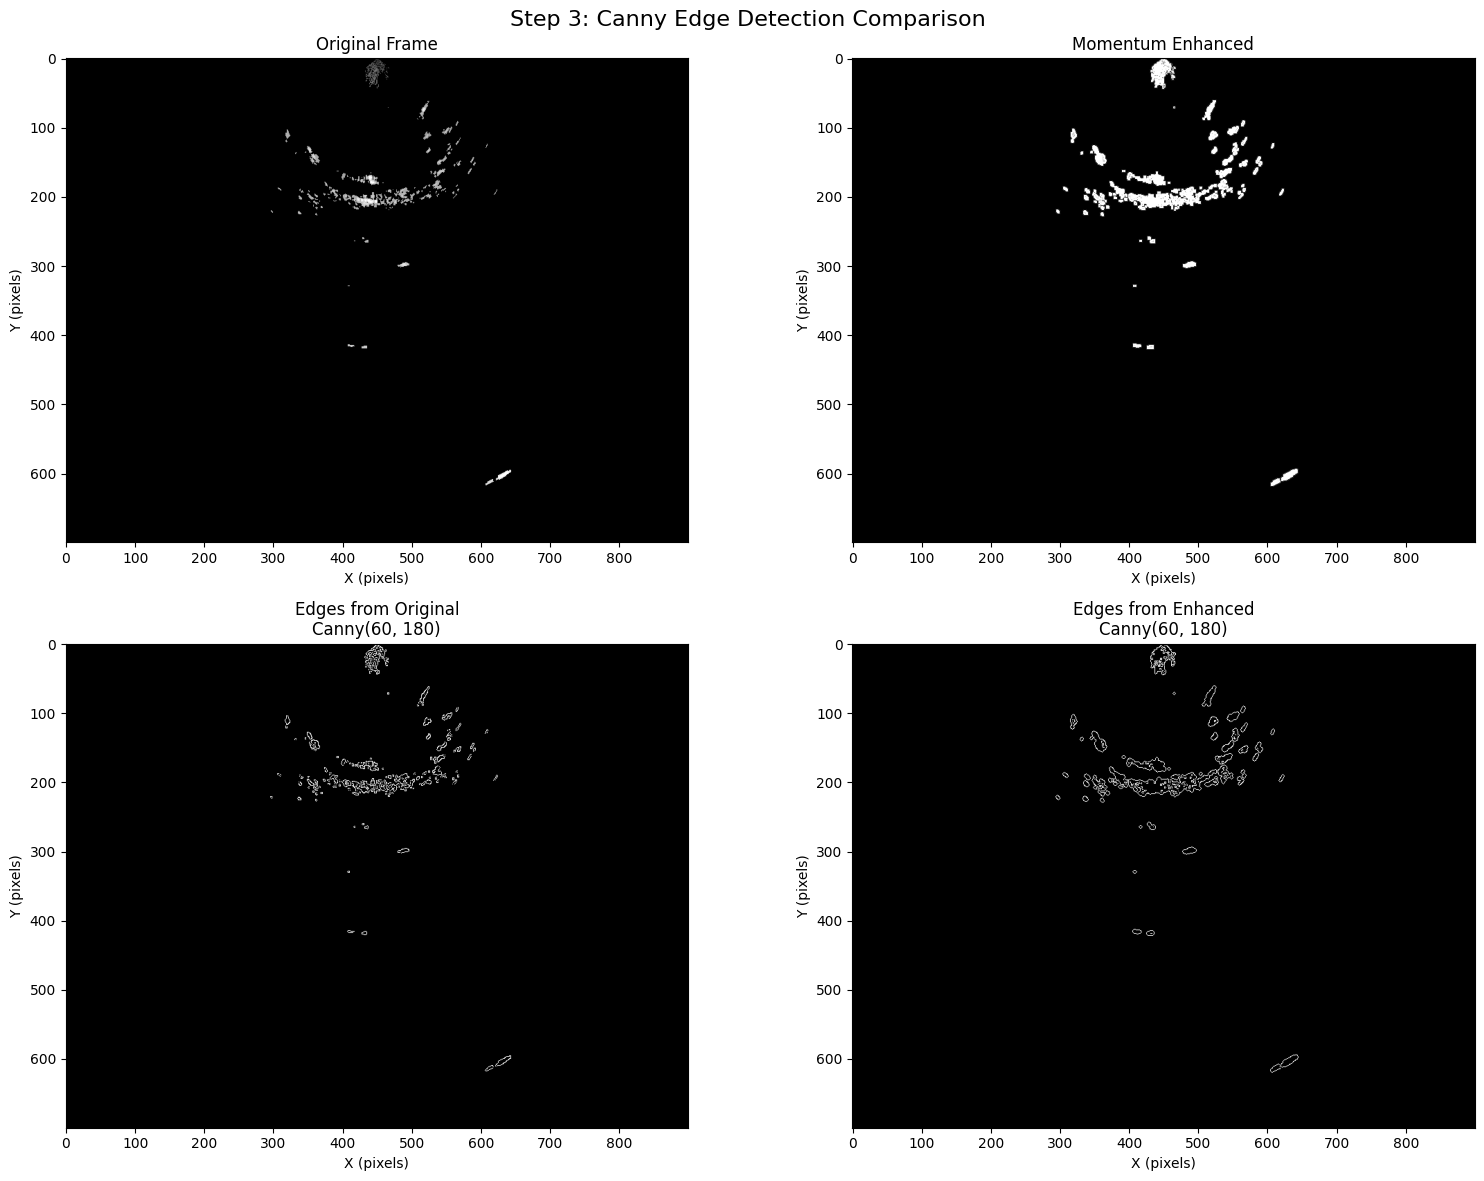

🔧 Canny Edge Detection Configuration:
   • Low threshold: 60
   • High threshold: 180

📊 Edge Detection Statistics:
   • Original edges: 2613/630000 (0.41%)
   • Enhanced edges: 2999/630000 (0.48%)
   • Enhancement improvement: +386 pixels (+0.06%)


In [14]:
# STEP 3: Edge Detection
if 'momentum_enhanced' in locals():
    # Apply Canny edge detection
    low_thresh = IMAGE_PROCESSING_CONFIG.get('canny_low_threshold', 50)
    high_thresh = IMAGE_PROCESSING_CONFIG.get('canny_high_threshold', 150)
    
    # Edges on original vs enhanced
    edges_original = cv2.Canny(demo_frame, low_thresh, high_thresh)
    edges_enhanced = cv2.Canny(momentum_enhanced, low_thresh, high_thresh)
    
    # Create comparison figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Original image
    axes[0,0].imshow(demo_frame, cmap='gray', aspect='equal')
    axes[0,0].set_title('Original Frame', fontsize=12)
    axes[0,0].set_xlabel('X (pixels)')
    axes[0,0].set_ylabel('Y (pixels)')
    
    # Enhanced image
    axes[0,1].imshow(momentum_enhanced, cmap='gray', aspect='equal')
    axes[0,1].set_title('Momentum Enhanced', fontsize=12)
    axes[0,1].set_xlabel('X (pixels)')
    axes[0,1].set_ylabel('Y (pixels)')
    
    # Edges from original
    axes[1,0].imshow(edges_original, cmap='gray', aspect='equal')
    axes[1,0].set_title(f'Edges from Original\nCanny({low_thresh}, {high_thresh})', fontsize=12)
    axes[1,0].set_xlabel('X (pixels)')
    axes[1,0].set_ylabel('Y (pixels)')
    
    # Edges from enhanced
    axes[1,1].imshow(edges_enhanced, cmap='gray', aspect='equal')
    axes[1,1].set_title(f'Edges from Enhanced\nCanny({low_thresh}, {high_thresh})', fontsize=12)
    axes[1,1].set_xlabel('X (pixels)')
    axes[1,1].set_ylabel('Y (pixels)')
    
    plt.suptitle('Step 3: Canny Edge Detection Comparison', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Edge statistics
    edge_count_orig = np.count_nonzero(edges_original)
    edge_count_enh = np.count_nonzero(edges_enhanced)
    total_pixels = edges_original.size
    
    print("🔧 Canny Edge Detection Configuration:")
    print(f"   • Low threshold: {low_thresh}")
    print(f"   • High threshold: {high_thresh}")
    
    print(f"\n📊 Edge Detection Statistics:")
    print(f"   • Original edges: {edge_count_orig}/{total_pixels} ({100*edge_count_orig/total_pixels:.2f}%)")
    print(f"   • Enhanced edges: {edge_count_enh}/{total_pixels} ({100*edge_count_enh/total_pixels:.2f}%)")
    print(f"   • Enhancement improvement: {edge_count_enh - edge_count_orig:+d} pixels ({100*(edge_count_enh - edge_count_orig)/total_pixels:+.2f}%)")
    
    # Store for next step
    globals()['edges_raw'] = edges_enhanced  # Use enhanced edges for further processing
else:
    print("❌ Momentum enhanced frame not available. Please run the previous cells first.")

## Step 4: Edge Processing - Morphological Operations

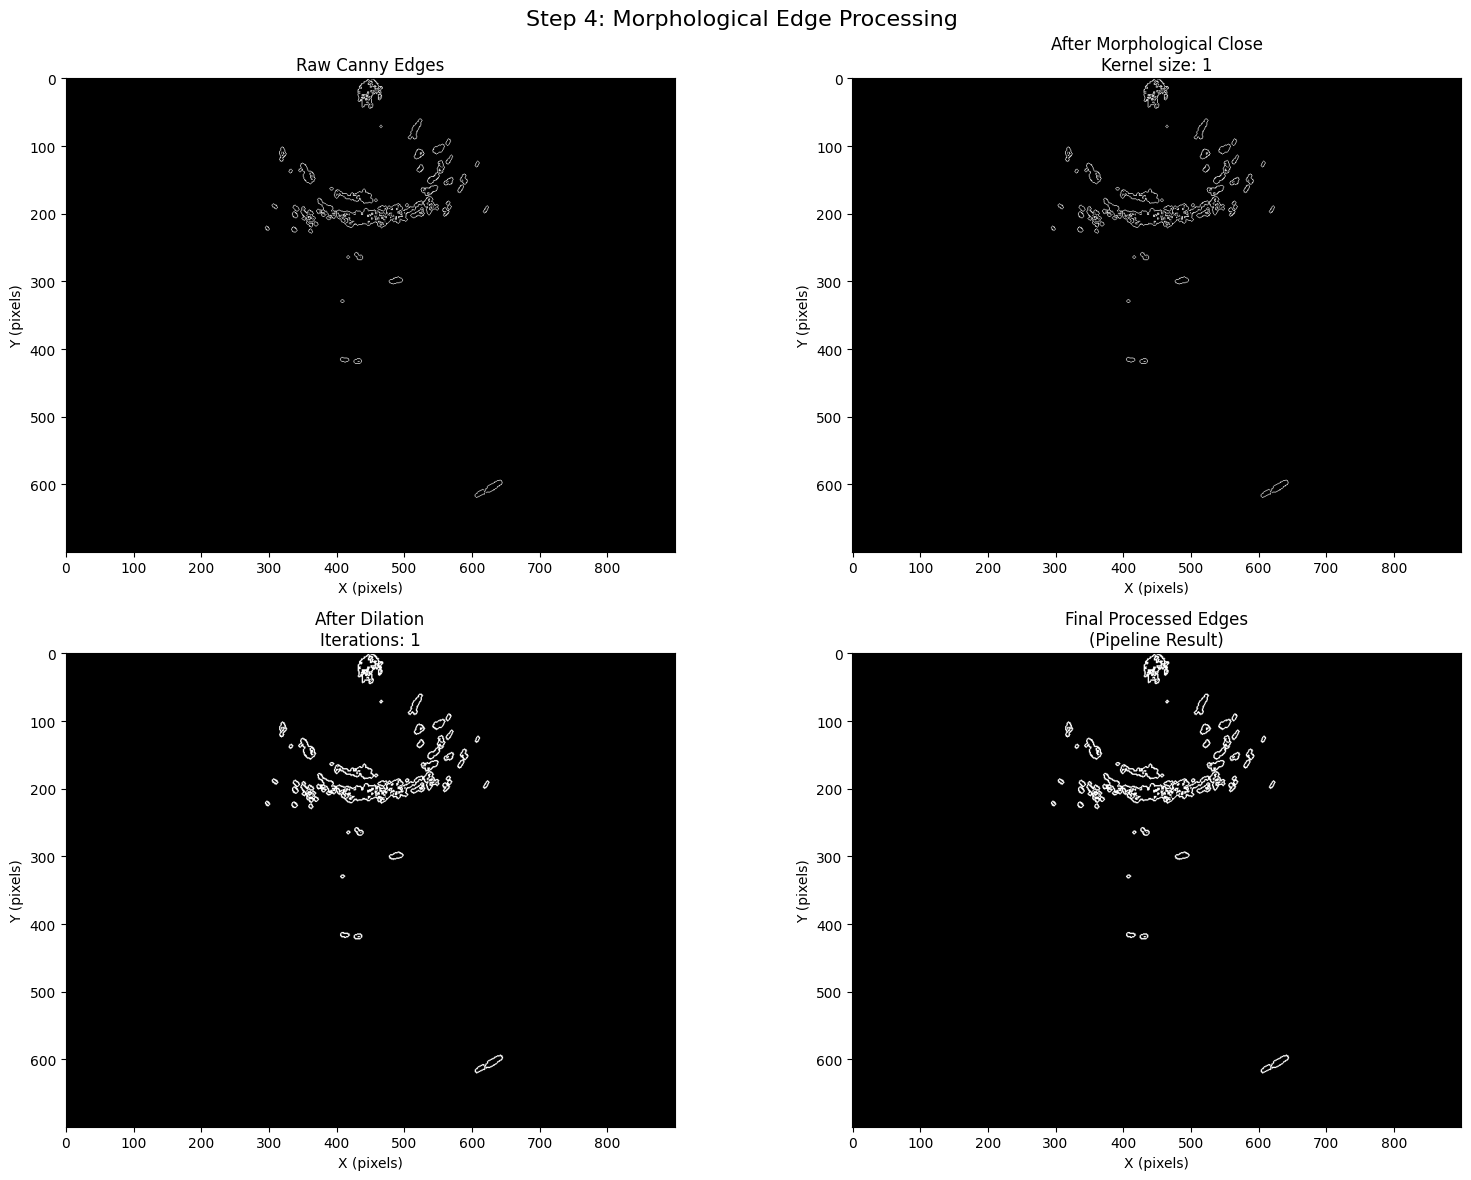

🔧 Morphological Processing Configuration:
   • Morphological close kernel: 1 (ENABLED)
   • Dilation iterations: 1 (ENABLED)

📊 Edge Processing Statistics:
   • Raw edges: 2999/630000 (0.48%)
   • After close: 2999/630000 (0.48%)
   • After dilate: 6345/630000 (1.01%)
   • Final processed: 6345/630000 (1.01%)


In [15]:
# STEP 4: Edge Processing with Morphological Operations
if 'edges_raw' in locals():
    # Get configuration parameters
    morph_kernel_size = int(IMAGE_PROCESSING_CONFIG.get('morph_close_kernel', 0))
    dilation_iterations = int(IMAGE_PROCESSING_CONFIG.get('edge_dilation_iterations', 0))
    
    # Apply preprocessing to get the full pipeline
    _, edges_processed = preprocess_edges(demo_frame, IMAGE_PROCESSING_CONFIG)
    
    # Show step-by-step morphological operations
    edges_after_close = edges_raw.copy()
    edges_after_dilate = edges_raw.copy()
    
    # Apply morphological close if configured
    if morph_kernel_size > 0:
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
        edges_after_close = cv2.morphologyEx(edges_raw, cv2.MORPH_CLOSE, kernel_close)
    
    # Apply dilation if configured
    if dilation_iterations > 0:
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        edges_after_dilate = cv2.dilate(edges_after_close, kernel_dilate, iterations=dilation_iterations)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Raw edges
    axes[0,0].imshow(edges_raw, cmap='gray', aspect='equal')
    axes[0,0].set_title('Raw Canny Edges', fontsize=12)
    axes[0,0].set_xlabel('X (pixels)')
    axes[0,0].set_ylabel('Y (pixels)')
    
    # After morphological close
    axes[0,1].imshow(edges_after_close, cmap='gray', aspect='equal')
    axes[0,1].set_title(f'After Morphological Close\nKernel size: {morph_kernel_size}' if morph_kernel_size > 0 else 'No Morphological Close\n(kernel size: 0)', fontsize=12)
    axes[0,1].set_xlabel('X (pixels)')
    axes[0,1].set_ylabel('Y (pixels)')
    
    # After dilation
    axes[1,0].imshow(edges_after_dilate, cmap='gray', aspect='equal')
    axes[1,0].set_title(f'After Dilation\nIterations: {dilation_iterations}' if dilation_iterations > 0 else 'No Dilation\n(iterations: 0)', fontsize=12)
    axes[1,0].set_xlabel('X (pixels)')
    axes[1,0].set_ylabel('Y (pixels)')
    
    # Final processed edges
    axes[1,1].imshow(edges_processed, cmap='gray', aspect='equal')
    axes[1,1].set_title('Final Processed Edges\n(Pipeline Result)', fontsize=12)
    axes[1,1].set_xlabel('X (pixels)')
    axes[1,1].set_ylabel('Y (pixels)')
    
    plt.suptitle('Step 4: Morphological Edge Processing', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    edge_count_raw = np.count_nonzero(edges_raw)
    edge_count_close = np.count_nonzero(edges_after_close)
    edge_count_dilate = np.count_nonzero(edges_after_dilate)
    edge_count_final = np.count_nonzero(edges_processed)
    total_pixels = edges_raw.size
    
    print("🔧 Morphological Processing Configuration:")
    print(f"   • Morphological close kernel: {morph_kernel_size} ({'ENABLED' if morph_kernel_size > 0 else 'DISABLED'})")
    print(f"   • Dilation iterations: {dilation_iterations} ({'ENABLED' if dilation_iterations > 0 else 'DISABLED'})")
    
    print(f"\n📊 Edge Processing Statistics:")
    print(f"   • Raw edges: {edge_count_raw}/{total_pixels} ({100*edge_count_raw/total_pixels:.2f}%)")
    print(f"   • After close: {edge_count_close}/{total_pixels} ({100*edge_count_close/total_pixels:.2f}%)")
    print(f"   • After dilate: {edge_count_dilate}/{total_pixels} ({100*edge_count_dilate/total_pixels:.2f}%)")
    print(f"   • Final processed: {edge_count_final}/{total_pixels} ({100*edge_count_final/total_pixels:.2f}%)")
    
    # Store for next step
    globals()['edges_processed'] = edges_processed
else:
    print("❌ Raw edges not available. Please run the previous cells first.")

## Step 5: Contour Detection - Find All Contours

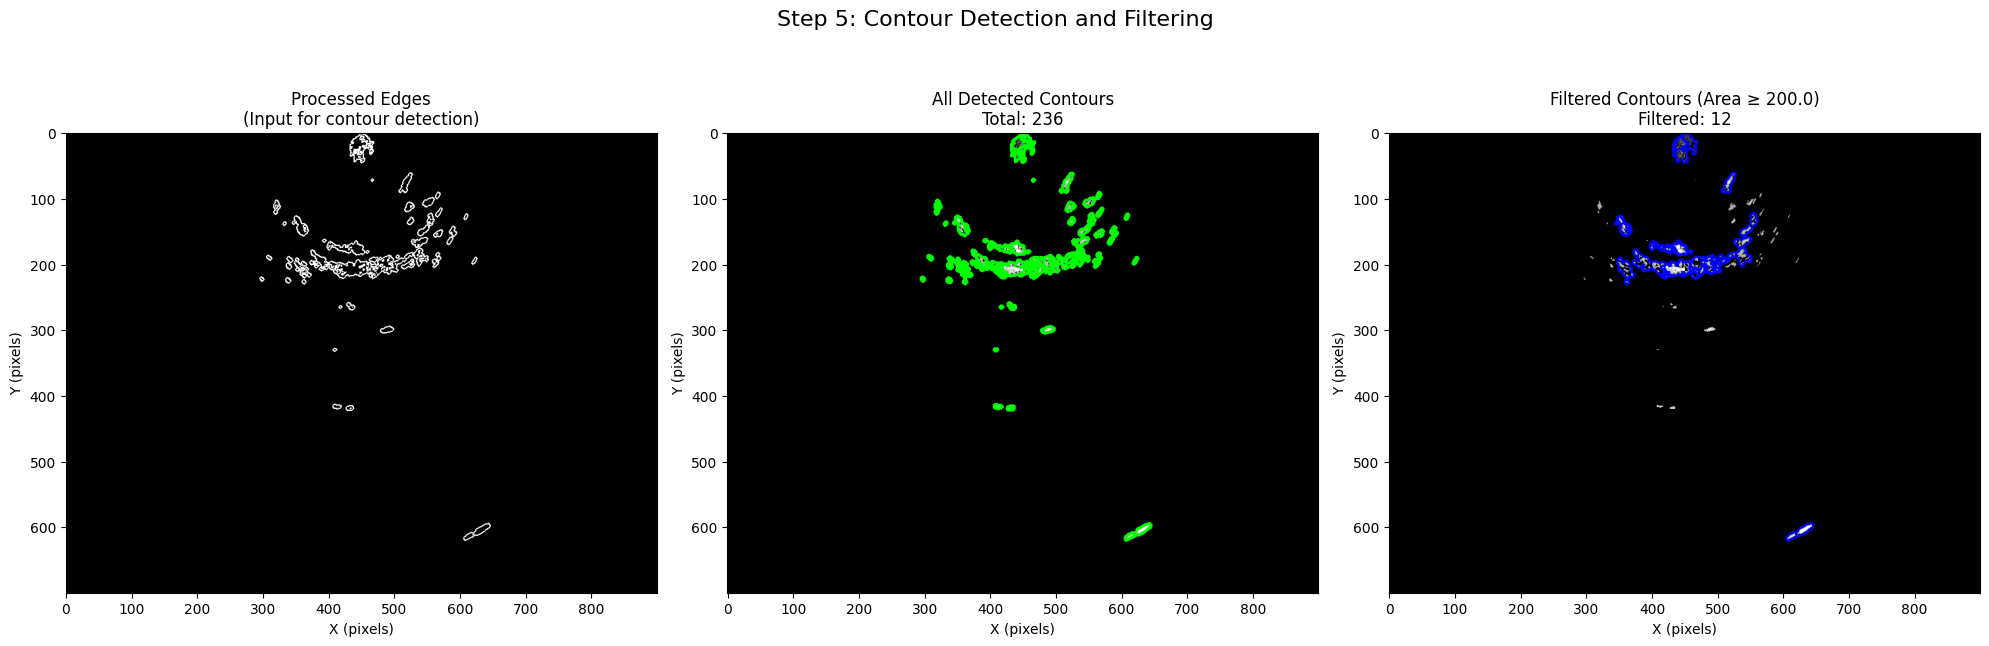

🔧 Contour Detection Configuration:
   • Contour retrieval mode: RETR_LIST
   • Contour approximation: CHAIN_APPROX_SIMPLE
   • Minimum area filter: 200.0

📊 Contour Statistics:
   • Total contours found: 236
   • After area filtering: 12
   • Filtered out: 224
   • Area range (all): 0.5 - 3617.0
   • Mean area (all): 64.1
   • Area range (filtered): 237.5 - 3617.0
   • Mean area (filtered): 790.5

🏆 Top 5 largest contours:
   1. Area: 3617.0, Bounding box: (370, 158) 182×65
   2. Area: 1325.0, Bounding box: (413, 187) 104×34
   3. Area: 1028.5, Bounding box: (431, 0) 38×46
   4. Area: 696.5, Bounding box: (396, 163) 66×24
   5. Area: 464.5, Bounding box: (346, 189) 28×42


In [16]:
# STEP 5: Contour Detection
if 'edges_processed' in locals():
    # Find contours
    contours, hierarchy = cv2.findContours(edges_processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter by minimum area
    min_area = float(IMAGE_PROCESSING_CONFIG.get('min_contour_area', 100))
    filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Processed edges
    axes[0].imshow(edges_processed, cmap='gray', aspect='equal')
    axes[0].set_title('Processed Edges\n(Input for contour detection)', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    
    # All contours
    all_contours_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    if contours:
        cv2.drawContours(all_contours_img, contours, -1, (0, 255, 0), 2)  # Green for all contours
    
    axes[1].imshow(cv2.cvtColor(all_contours_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[1].set_title(f'All Detected Contours\nTotal: {len(contours)}', fontsize=12)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    
    # Filtered contours
    filtered_contours_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    if filtered_contours:
        cv2.drawContours(filtered_contours_img, filtered_contours, -1, (255, 0, 0), 2)  # Red for filtered contours
    
    axes[2].imshow(cv2.cvtColor(filtered_contours_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[2].set_title(f'Filtered Contours (Area ≥ {min_area})\nFiltered: {len(filtered_contours)}', fontsize=12)
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    
    plt.suptitle('Step 5: Contour Detection and Filtering', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Contour statistics
    if contours:
        areas = [cv2.contourArea(c) for c in contours]
        filtered_areas = [cv2.contourArea(c) for c in filtered_contours]
        
        print("🔧 Contour Detection Configuration:")
        print(f"   • Contour retrieval mode: RETR_LIST")
        print(f"   • Contour approximation: CHAIN_APPROX_SIMPLE")
        print(f"   • Minimum area filter: {min_area}")
        
        print(f"\n📊 Contour Statistics:")
        print(f"   • Total contours found: {len(contours)}")
        print(f"   • After area filtering: {len(filtered_contours)}")
        print(f"   • Filtered out: {len(contours) - len(filtered_contours)}")
        
        if areas:
            print(f"   • Area range (all): {min(areas):.1f} - {max(areas):.1f}")
            print(f"   • Mean area (all): {np.mean(areas):.1f}")
            
        if filtered_areas:
            print(f"   • Area range (filtered): {min(filtered_areas):.1f} - {max(filtered_areas):.1f}")
            print(f"   • Mean area (filtered): {np.mean(filtered_areas):.1f}")
            
        # Show top 5 largest contours
        sorted_contours = sorted(enumerate(filtered_contours), key=lambda x: cv2.contourArea(x[1]), reverse=True)
        print(f"\n🏆 Top {min(5, len(sorted_contours))} largest contours:")
        for i, (orig_idx, contour) in enumerate(sorted_contours[:5]):
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            print(f"   {i+1}. Area: {area:.1f}, Bounding box: ({x}, {y}) {w}×{h}")
    else:
        print("❌ No contours found!")
        
    # Store for next step
    globals()['all_contours'] = contours
    globals()['filtered_contours'] = filtered_contours
else:
    print("❌ Processed edges not available. Please run the previous cells first.")

## Step 6: Contour Selection - Choose Best Net Candidate

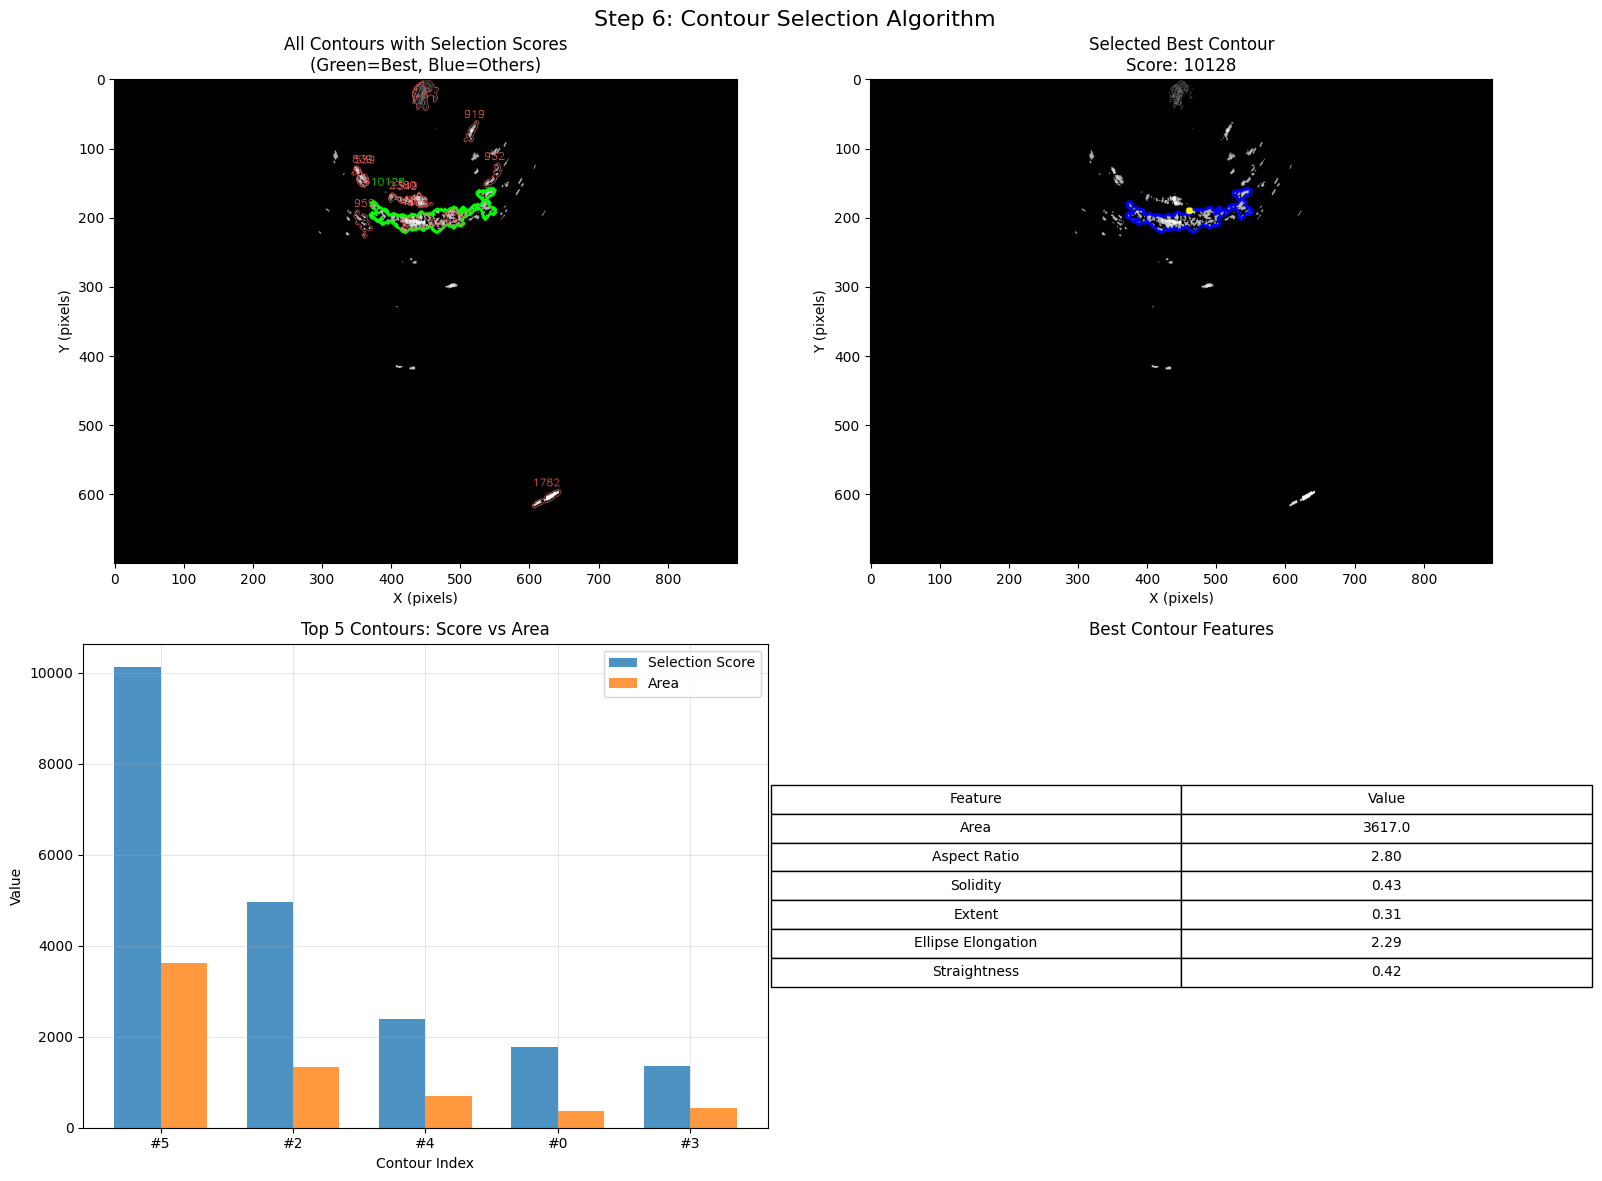

🔧 Contour Selection Configuration:
   • Selection algorithm: Core (area × elongation)
   • Elongation metric: max(aspect_ratio, ellipse_elongation)
   • AOI boost: Not applied (demo mode)
   • Distance penalty: Not applied (no previous position)

📊 Selection Statistics:
   • Candidates evaluated: 12
   • Best score: 10127.6

🏆 Best Contour Details:
   • Area: 3617.0 pixels²
   • Aspect ratio: 2.80
   • Ellipse elongation: 2.29
   • Solidity: 0.43 (convex hull fill)
   • Extent: 0.31 (bounding box fill)
   • Straightness: 0.42 (line fit quality)
   • Centroid: (461.0, 190.5)


In [17]:
# STEP 6: Contour Selection
if 'filtered_contours' in locals() and filtered_contours:
    # Use the core contour selection algorithm
    best_contour, best_features, selection_stats = select_best_contour_core(
        filtered_contours, 
        last_center=None,  # No previous tracking for demo
        aoi=None,          # No AOI for demo
        cfg_img=IMAGE_PROCESSING_CONFIG
    )
    
    # Compute features for all contours for comparison
    all_contour_features = []
    for i, contour in enumerate(filtered_contours):
        features = compute_contour_features(contour)
        features['contour_index'] = i
        features['area'] = cv2.contourArea(contour)
        
        # Compute the score used by the selection algorithm
        elongation = max(features['aspect_ratio'], features['ellipse_elongation'])
        features['selection_score'] = features['area'] * elongation
        
        all_contour_features.append(features)
    
    # Sort by selection score
    all_contour_features.sort(key=lambda x: x['selection_score'], reverse=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # All filtered contours with scores
    all_scored_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    for i, features in enumerate(all_contour_features):
        contour = filtered_contours[features['contour_index']]
        color = (0, 255, 0) if i == 0 else (100, 100, 255)  # Green for best, light blue for others
        thickness = 3 if i == 0 else 1
        cv2.drawContours(all_scored_img, [contour], -1, color, thickness)
        
        # Add score text
        x, y, w, h = cv2.boundingRect(contour)
        score_text = f"{features['selection_score']:.0f}"
        cv2.putText(all_scored_img, score_text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    axes[0,0].imshow(cv2.cvtColor(all_scored_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[0,0].set_title('All Contours with Selection Scores\n(Green=Best, Blue=Others)', fontsize=12)
    axes[0,0].set_xlabel('X (pixels)')
    axes[0,0].set_ylabel('Y (pixels)')
    
    # Best contour only
    if best_contour is not None:
        best_contour_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(best_contour_img, [best_contour], -1, (255, 0, 0), 3)  # Red for best
        
        # Add centroid
        if best_features:
            cx, cy = int(best_features['centroid_x']), int(best_features['centroid_y'])
            cv2.circle(best_contour_img, (cx, cy), 5, (0, 255, 255), -1)  # Yellow center
            
        axes[0,1].imshow(cv2.cvtColor(best_contour_img, cv2.COLOR_BGR2RGB), aspect='equal')
        axes[0,1].set_title(f'Selected Best Contour\nScore: {selection_stats.get("best_score", 0):.0f}', fontsize=12)
        axes[0,1].set_xlabel('X (pixels)')
        axes[0,1].set_ylabel('Y (pixels)')
    else:
        axes[0,1].text(0.5, 0.5, 'No Best Contour\nSelected', ha='center', va='center', 
                      transform=axes[0,1].transAxes, fontsize=14)
        axes[0,1].set_title('No Selection Made', fontsize=12)
    
    # Feature comparison bar chart
    if len(all_contour_features) > 0:
        top_5_features = all_contour_features[:5]  # Top 5 by score
        indices = [f"#{f['contour_index']}" for f in top_5_features]
        scores = [f['selection_score'] for f in top_5_features]
        areas = [f['area'] for f in top_5_features]
        
        x = np.arange(len(indices))
        width = 0.35
        
        axes[1,0].bar(x - width/2, scores, width, label='Selection Score', alpha=0.8)
        axes[1,0].bar(x + width/2, areas, width, label='Area', alpha=0.8)
        axes[1,0].set_xlabel('Contour Index')
        axes[1,0].set_ylabel('Value')
        axes[1,0].set_title('Top 5 Contours: Score vs Area')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(indices)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Feature details table for best contour
    if best_features:
        feature_names = ['Area', 'Aspect Ratio', 'Solidity', 'Extent', 'Ellipse Elongation', 'Straightness']
        feature_values = [
            f"{best_features.get('area', 0):.1f}",
            f"{best_features.get('aspect_ratio', 0):.2f}",
            f"{best_features.get('solidity', 0):.2f}",
            f"{best_features.get('extent', 0):.2f}",
            f"{best_features.get('ellipse_elongation', 0):.2f}",
            f"{best_features.get('straightness', 0):.2f}"
        ]
        
        axes[1,1].axis('tight')
        axes[1,1].axis('off')
        table_data = list(zip(feature_names, feature_values))
        table = axes[1,1].table(cellText=table_data, colLabels=['Feature', 'Value'],
                               cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        axes[1,1].set_title('Best Contour Features', fontsize=12)
    
    plt.suptitle('Step 6: Contour Selection Algorithm', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("🔧 Contour Selection Configuration:")
    print(f"   • Selection algorithm: Core (area × elongation)")
    print(f"   • Elongation metric: max(aspect_ratio, ellipse_elongation)")
    print(f"   • AOI boost: Not applied (demo mode)")
    print(f"   • Distance penalty: Not applied (no previous position)")
    
    print(f"\n📊 Selection Statistics:")
    print(f"   • Candidates evaluated: {selection_stats.get('total_contours', 0)}")
    print(f"   • Best score: {selection_stats.get('best_score', 0):.1f}")
    
    if best_features:
        print(f"\n🏆 Best Contour Details:")
        print(f"   • Area: {best_features.get('area', 0):.1f} pixels²")
        print(f"   • Aspect ratio: {best_features.get('aspect_ratio', 0):.2f}")
        print(f"   • Ellipse elongation: {best_features.get('ellipse_elongation', 0):.2f}")
        print(f"   • Solidity: {best_features.get('solidity', 0):.2f} (convex hull fill)")
        print(f"   • Extent: {best_features.get('extent', 0):.2f} (bounding box fill)")
        print(f"   • Straightness: {best_features.get('straightness', 0):.2f} (line fit quality)")
        print(f"   • Centroid: ({best_features.get('centroid_x', 0):.1f}, {best_features.get('centroid_y', 0):.1f})")
    
    # Store for next step
    globals()['best_contour'] = best_contour
    globals()['best_features'] = best_features
    
elif 'filtered_contours' in locals():
    print("❌ No filtered contours available for selection!")
else:
    print("❌ Filtered contours not available. Please run the previous cells first.")

## Step 7: Final Result - Distance Measurement and Tracking

/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_99381/1098378410.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_99381/1098378410.py:134: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_99381/1098378410.py:134: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_99381/1098378410.py:134: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_99381/1098378410.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/x9/scyyg02s20v075

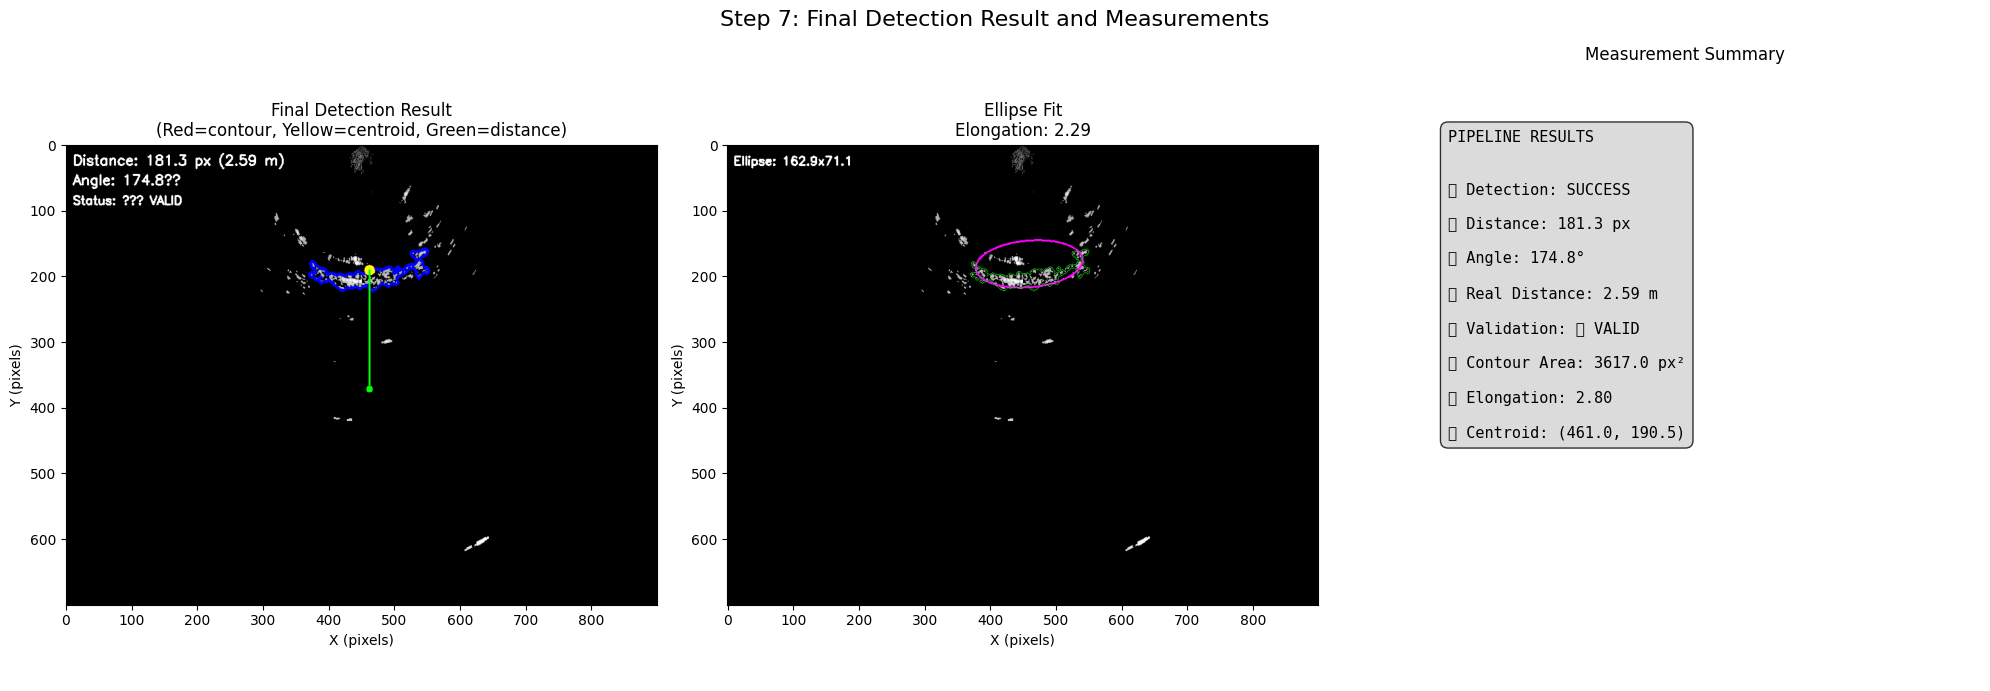

🎯 NET DETECTION PIPELINE COMPLETE!
✅ Detection Status: SUCCESS
📏 Distance: 181.3 pixels
🌍 Real Distance: 2.59 meters
📐 Angle: 174.8 degrees
🔍 Validation: ✅ VALID
📊 Processing Config: VALIDATION ON


In [18]:
# STEP 7: Final Result - Distance Measurement and Tracking
if 'best_contour' in locals() and best_contour is not None and 'best_features' in locals():
    # Calculate distance and angle using the utility function
    
    H, W = demo_frame.shape
    distance_pixels, angle_degrees = _distance_angle_from_contour(best_contour, W, H)
    
    # Apply distance validation if configured
    if IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True):
        # For demo, we don't have previous state, so just validate bounds
        if distance_pixels is not None:
            if 0 <= distance_pixels <= H:
                validated_distance = distance_pixels
                validation_status = "✅ VALID"
            else:
                validated_distance = None
                validation_status = f"❌ INVALID (out of bounds: {distance_pixels:.1f})"
        else:
            validated_distance = None
            validation_status = "❌ INVALID (no distance detected)"
    else:
        validated_distance = distance_pixels
        validation_status = "⚠️ NOT VALIDATED (validation disabled)"
    
    # Convert to meters using the extent if available
    distance_meters = None
    if validated_distance is not None and 'extent' in locals():
        x_min, x_max, y_min, y_max = extent
        height_m = y_max - y_min
        px2m_y = height_m / H
        distance_meters = y_min + validated_distance * px2m_y
    
    # Create final visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Final result overlay
    result_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    
    # Draw the best contour
    cv2.drawContours(result_img, [best_contour], -1, (255, 0, 0), 3)  # Red contour
    
    # Draw centroid
    if best_features:
        cx, cy = int(best_features['centroid_x']), int(best_features['centroid_y'])
        cv2.circle(result_img, (cx, cy), 8, (0, 255, 255), -1)  # Yellow center
        
        # Draw distance line to bottom of image
        if validated_distance is not None:
            distance_y = int(cy + validated_distance)
            cv2.line(result_img, (cx, cy), (cx, distance_y), (0, 255, 0), 2)  # Green distance line
            cv2.circle(result_img, (cx, distance_y), 5, (0, 255, 0), -1)  # Green end point
    
    # Add text overlay with measurements
    if validated_distance is not None:
        dist_text = f"Distance: {validated_distance:.1f} px"
        if distance_meters is not None:
            dist_text += f" ({distance_meters:.2f} m)"
        cv2.putText(result_img, dist_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
    if angle_degrees is not None:
        angle_text = f"Angle: {angle_degrees:.1f}°"
        cv2.putText(result_img, angle_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    status_text = f"Status: {validation_status}"
    cv2.putText(result_img, status_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    axes[0].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB), aspect='equal')
    axes[0].set_title('Final Detection Result\n(Red=contour, Yellow=centroid, Green=distance)', fontsize=12)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Y (pixels)')
    
    # Ellipse fitting if possible
    ellipse_img = cv2.cvtColor(demo_frame, cv2.COLOR_GRAY2BGR)
    if len(best_contour) >= 5:
        try:
            ellipse = cv2.fitEllipse(best_contour)
            cv2.ellipse(ellipse_img, ellipse, (255, 0, 255), 2)  # Magenta ellipse
            cv2.drawContours(ellipse_img, [best_contour], -1, (0, 255, 0), 1)  # Green contour for comparison
            
            # Ellipse info
            (cx, cy), (minor_axis, major_axis), angle = ellipse
            ellipse_elongation = major_axis / minor_axis if minor_axis > 0 else 0
            
            ellipse_text = f"Ellipse: {major_axis:.1f}x{minor_axis:.1f}"
            cv2.putText(ellipse_img, ellipse_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            axes[1].imshow(cv2.cvtColor(ellipse_img, cv2.COLOR_BGR2RGB), aspect='equal')
            axes[1].set_title(f'Ellipse Fit\nElongation: {ellipse_elongation:.2f}', fontsize=12)
        except:
            axes[1].text(0.5, 0.5, 'Ellipse Fitting\nFailed', ha='center', va='center', 
                        transform=axes[1].transAxes, fontsize=14)
            axes[1].set_title('Ellipse Fit (Failed)', fontsize=12)
    else:
        axes[1].text(0.5, 0.5, 'Too Few Points\nfor Ellipse', ha='center', va='center', 
                    transform=axes[1].transAxes, fontsize=14)
        axes[1].set_title('Ellipse Fit (N/A)', fontsize=12)
    
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Y (pixels)')
    
    # Results summary
    axes[2].axis('off')
    
    # Build summary text step by step to avoid f-string complexity
    summary_lines = [
        "PIPELINE RESULTS",
        "",
        "",
        f"🎯 Detection: {'SUCCESS' if best_contour is not None else 'FAILED'}",
        "",
        f"📏 Distance: {validated_distance:.1f} px" if validated_distance else "📏 Distance: N/A",
        "",
        f"📐 Angle: {angle_degrees:.1f}°" if angle_degrees else "📐 Angle: N/A",
        "",
        f"🌍 Real Distance: {distance_meters:.2f} m" if distance_meters else "🌍 Real Distance: N/A",
        "",
        f"✅ Validation: {validation_status}",
        "",
        f"📊 Contour Area: {best_features.get('area', 0):.1f} px²",
        "",
        f"🔄 Elongation: {max(best_features.get('aspect_ratio', 0), best_features.get('ellipse_elongation', 0)):.2f}",
        "",
        f"📍 Centroid: ({best_features.get('centroid_x', 0):.1f}, {best_features.get('centroid_y', 0):.1f})"
    ]
    
    summary_text = "\n".join(summary_lines)
    
    axes[2].text(0.1, 0.9, summary_text, transform=axes[2].transAxes, fontsize=11, 
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    axes[2].set_title('Measurement Summary', fontsize=12)
    
    plt.suptitle('Step 7: Final Detection Result and Measurements', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print final summary
    print("🎯 NET DETECTION PIPELINE COMPLETE!")
    print("="*50)
    print(f"✅ Detection Status: {'SUCCESS' if best_contour is not None else 'FAILED'}")
    if validated_distance is not None:
        print(f"📏 Distance: {validated_distance:.1f} pixels")
        if distance_meters is not None:
            print(f"🌍 Real Distance: {distance_meters:.2f} meters")
    if angle_degrees is not None:
        print(f"📐 Angle: {angle_degrees:.1f} degrees")
    print(f"🔍 Validation: {validation_status}")
    validation_config = 'VALIDATION ON' if IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True) else 'VALIDATION OFF'
    print(f"📊 Processing Config: {validation_config}")
    
else:
    print("❌ No best contour available for final measurement.")
    print("💡 This could mean no suitable net candidate was found in the image.")
    
    # Show what we have
    if 'demo_frame' in locals():
        plt.figure(figsize=(10, 8))
        plt.imshow(demo_frame, cmap='gray')
        plt.title('No Detection Result\nNo suitable net contour found', fontsize=14)
        plt.colorbar(label='Intensity')
        plt.xlabel('X (pixels)')
        plt.ylabel('Y (pixels)')
        plt.tight_layout()
        plt.show()
        
        print("\n🔧 Troubleshooting suggestions:")
        print("   • Try adjusting IMAGE_PROCESSING_CONFIG parameters")
        print("   • Check if the frame contains visible net structures")
        print("   • Lower min_contour_area threshold")
        print("   • Adjust Canny edge detection thresholds")

## 🎛️ Interactive Pipeline Controller

Use this section to experiment with different pipeline parameters and see their effects on each step.

In [ ]:
# Interactive Pipeline Parameter Adjustment
print("🎛️ PIPELINE PARAMETER CONTROL PANEL")
print("="*50)
print("Modify these parameters and re-run the pipeline steps to see their effects:\n")

print("📊 Current Configuration:")
print(f"   • Canny Low Threshold: {IMAGE_PROCESSING_CONFIG.get('canny_low_threshold', 50)}")
print(f"   • Canny High Threshold: {IMAGE_PROCESSING_CONFIG.get('canny_high_threshold', 150)}")
print(f"   • Morphological Close Kernel: {IMAGE_PROCESSING_CONFIG.get('morph_close_kernel', 0)}")
print(f"   • Edge Dilation Iterations: {IMAGE_PROCESSING_CONFIG.get('edge_dilation_iterations', 0)}")
print(f"   • Minimum Contour Area: {IMAGE_PROCESSING_CONFIG.get('min_contour_area', 100)}")
print(f"   • Distance Validation: {IMAGE_PROCESSING_CONFIG.get('use_distance_validation', True)}")
print(f"   • Momentum Search Radius: {IMAGE_PROCESSING_CONFIG.get('momentum_search_radius', 3)}")
print(f"   • Momentum Threshold: {IMAGE_PROCESSING_CONFIG.get('momentum_threshold', 0.2)}")

print("\n🔧 To experiment, uncomment and modify any of these lines:")
print("# IMAGE_PROCESSING_CONFIG['canny_low_threshold'] = 30      # Lower = more edges")
print("# IMAGE_PROCESSING_CONFIG['canny_high_threshold'] = 200    # Higher = fewer edges")
print("# IMAGE_PROCESSING_CONFIG['morph_close_kernel'] = 3        # Connect nearby edges")
print("# IMAGE_PROCESSING_CONFIG['edge_dilation_iterations'] = 2  # Thicken edges")
print("# IMAGE_PROCESSING_CONFIG['min_contour_area'] = 50         # Allow smaller contours")
print("# IMAGE_PROCESSING_CONFIG['use_distance_validation'] = False  # Disable validation")

print("\n📝 After modifying parameters, re-run the pipeline steps (cells 3-7) to see changes!")
print("💡 Try different frame indices by changing DEMO_FRAME_INDEX in the import cell.")

# Quick parameter modification examples (commented out)
# Uncomment any of these to quickly test different settings:

# More sensitive edge detection
# IMAGE_PROCESSING_CONFIG['canny_low_threshold'] = 30
# IMAGE_PROCESSING_CONFIG['canny_high_threshold'] = 120

# Edge enhancement
# IMAGE_PROCESSING_CONFIG['morph_close_kernel'] = 3
# IMAGE_PROCESSING_CONFIG['edge_dilation_iterations'] = 1

# More permissive contour detection
# IMAGE_PROCESSING_CONFIG['min_contour_area'] = 50

print("\n🎯 Current Demo Frame Index:", DEMO_FRAME_INDEX)
print("🔄 To analyze a different frame, change DEMO_FRAME_INDEX and re-run from the import cell!")

# Simple Image Analysis with CV2

This notebook demonstrates:
1. **Pick a frame** from NPZ files and save it locally
2. **Use standard cv2 functions** directly for image processing
3. **Experiment** with different OpenCV operations

## Distance Analysis Over Time

Now let's perform a comprehensive analysis of the red line distance over time. The red line represents the major axis of the detected elongated contour (likely a fishing net), and we'll track how this distance changes throughout the video sequence.

In [6]:
# Create video using the CORE simplified processor with ELLIPTICAL AOI
# This will now show the yellow ELLIPTICAL AOI instead of rectangular!

# Use the enhanced video creation with CORE processor
video_path = iau.create_enhanced_contour_detection_video_with_processor(
    npz_file_index=NPZ_FILE_INDEX,          # Which NPZ file to use
    frame_start=1,           # Starting frame
    frame_count=1500,         # Start with 1500 frames for testing
    frame_step=1,            # Step between frames
    output_path=Path(EXPORTS_DIR_DEFAULT) / EXPORTS_SUBDIRS.get('videos','videos') / 'elliptical_aoi_tracking.mp4',
    processor=processor      # Use our CORE processor with ellipse tracking
)

print(f"✅ Video created with ELLIPTICAL AOI visualization!")
print(f"🎯 The AOI should now appear as a yellow ELLIPSE that smoothly tracks the net")
print(f"📁 Video saved to: {video_path}")

=== ENHANCED ELLIPTICAL AOI VIDEO CREATION ===
Creating video with elliptical AOI tracking...
Frames: 1500, step: 1
✅ Processing 1059 frames with elliptical AOI...
✅ Processing 1059 frames with elliptical AOI...
Processed 10/1059 frames | Ellipse tracking: 0
Processed 10/1059 frames | Ellipse tracking: 0
Processed 20/1059 frames | Ellipse tracking: 0
Processed 20/1059 frames | Ellipse tracking: 0
Processed 30/1059 frames | Ellipse tracking: 0
Processed 30/1059 frames | Ellipse tracking: 0
Processed 40/1059 frames | Ellipse tracking: 0
Processed 40/1059 frames | Ellipse tracking: 0
Processed 50/1059 frames | Ellipse tracking: 0
Processed 50/1059 frames | Ellipse tracking: 0
Processed 60/1059 frames | Ellipse tracking: 0
Processed 60/1059 frames | Ellipse tracking: 0
Processed 70/1059 frames | Ellipse tracking: 0
Processed 70/1059 frames | Ellipse tracking: 0
Processed 80/1059 frames | Ellipse tracking: 0
Processed 80/1059 frames | Ellipse tracking: 0
Processed 90/1059 frames | Ellipse t

## Convert to Real-World Distances

Now let's convert the pixel distances to real-world distances using the fact that the entire sonar image represents a 10x10 meter area.

In [8]:
# Real-world distance analysis and plotting using utility function
iau.plot_real_world_distance_analysis(distance_results, image_shape=image_shape, sonar_coverage_meters=sonar_coverage_meters)

In [10]:
try:
    fig, comparison_stats = iau.interactive_distance_comparison(distance_results, raw_data, sonar_coverage_m=sonar_coverage_meters, sonar_image_size=image_shape[0])
    if comparison_stats and isinstance(comparison_stats, dict) and 'error' in comparison_stats:
        print('Comparison did not run:', comparison_stats['error'])
    else:
        print('\nComparison stats summary:')
        from pprint import pprint
        pprint(comparison_stats)
        # Display the interactive plot
        fig.show()
except Exception as e:
    print('Error running interactive comparison:', e)

/Users/eirikvarnes/code/SOLAQUA/utils/sonar_image_analysis.py:496: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/eirikvarnes/code/SOLAQUA/utils/sonar_image_analysis.py:503: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




📊 SONAR vs DVL COMPARISON STATISTICS:
Sonar mean distance: 2.043 m
DVL mean distance:   1.968 m
Scale ratio (Sonar/DVL): 1.038x
Sonar duration: 67.1s (1059 frames)
DVL duration:   67.0s (559 records)

Comparison stats summary:
{'dvl_duration_s': 67.007197142,
 'dvl_mean_m': 1.9676565289337435,
 'dvl_records': 559,
 'scale_ratio': 1.0384467682649405,
 'sonar_duration_s': 67.07053097672778,
 'sonar_frames': 1059,
 'sonar_mean_m': 2.0433065635266563}
